In [1]:
# !pip install rioxarray

In [17]:
import psycopg2
from rasterio.io import MemoryFile
import rioxarray as riox
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

In [3]:
conn = psycopg2.connect("dbname='gis' user='gis' host='postgis' password='password'")

In [4]:
q1 = '''
    SELECT ogc_fid, statefp, name
    FROM or_us_county county
    WHERE ogc_fid = 1
'''

q2 = '''
    SET postgis.gdal_enabled_drivers = 'ENABLE_ALL';

    WITH county AS (
        SELECT ogc_fid, statefp, name, wkb_geometry as geometry
        FROM or_us_county 
        WHERE ogc_fid = 1
    )
    SELECT 
        ST_AsGDALRaster(ST_Clip(raster.rast, county.geometry, true), 'GTIFF') 
    FROM or_forest_own as raster 
    INNER JOIN county
        ON ST_INTERSECTS(county.geometry, raster.rast)
    --LIMIT 1000
'''

In [5]:
with conn.cursor() as cur:
    cur.execute(q1)
    print(cur.fetchone())

(1, '41', 'Clackamas')


In [6]:
def get_pixels(query):
    with conn.cursor() as cur:
        cur.execute(query)
        res = cur.fetchall()

    raster_bytes = [MemoryFile(bytes(res[i][0])) for i in range(len(res))]
    raster = merge_arrays([riox.open_rasterio(rb) for rb in raster_bytes])
    return raster

In [7]:
%time
raster = get_pixels(q2)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 4.29 μs


In [8]:
raster.shape

(2, 2702, 3059)

In [9]:
raster[0]

<xarray.DataArray (y: 2702, x: 3059)> Size: 8MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x            (x) float64 24kB -2.08e+06 -2.08e+06 ... -1.988e+06 -1.988e+06
  * y            (y) float64 22kB 2.787e+06 2.787e+06 ... 2.706e+06 2.706e+06
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

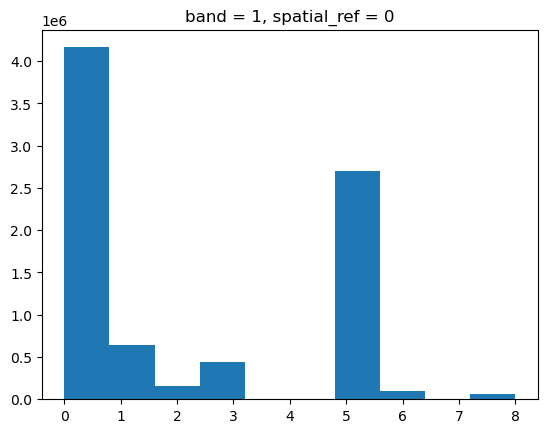

In [10]:
raster[0].plot.hist()
plt.show()

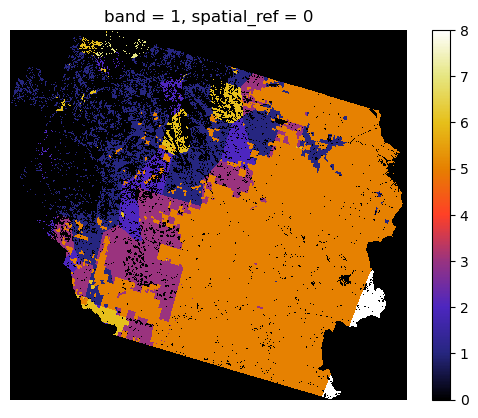

In [11]:
f, ax = plt.subplots()
raster[0].plot(cmap="CMRmap", ax=ax)
ax.set_axis_off()
plt.show()

Use [ST_DumpValues](https://postgis.net/docs/RT_ST_DumpValues.html) to acces only raster values. In this query, spatial information is lost.

Compute value counts in sql if you only need an histogram, intead of retrieving all pixel values. Some examples [here](https://postgis.net/documentation/tips/tip_count_of_pixel_values/).  

In [12]:
q3 = '''
    SET postgis.gdal_enabled_drivers = 'ENABLE_ALL';

    WITH dump AS (
        WITH county AS (
            SELECT ogc_fid, statefp, name, wkb_geometry as geometry
            FROM or_us_county 
            WHERE ogc_fid = 1
        )
        SELECT 
            ST_Clip(ST_SetBandNoDataValue(raster.rast, 1, 0), 1, county.geometry, 0, true) as rast
        FROM or_forest_own as raster 
        INNER JOIN county
            ON ST_INTERSECTS(county.geometry, raster.rast)
    )
    SELECT
        (ST_DumpValues(rast, exclude_nodata_value => FALSE)).*
    FROM dump;
'''

In [24]:
def get_values(query):
    conn = psycopg2.connect("dbname='gis' user='gis' host='postgis' password='password'")
    with conn.cursor() as cur:
        cur.execute(query)
        res = cur.fetchall()
    conn.close()
    #filter and flatten res list
    vlist = itertools.chain.from_iterable([item[1] for item in res])
    vlist = list(itertools.chain.from_iterable(vlist))
    return np.array(vlist)

In [26]:
%time
values = get_values(q3)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 μs


<Axes: >

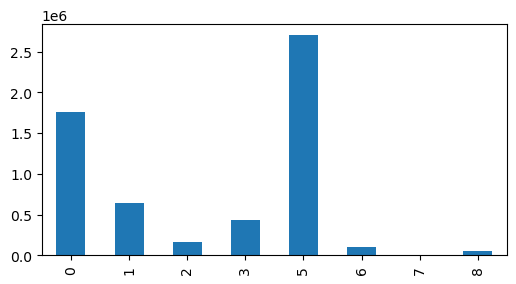

In [32]:
pd.Series(values).astype(int).sort_values().value_counts(sort=False).plot.bar(figsize=(6, 3))